# Machine Learning Portfolio 2

|Name|Github|Kaggle|
|----|------|------|
|Henry Lau|HenryLau08|Henry Lau|
|Mohamed Belaachir|mobelaachir|Mo Belaachir|
|Jayden Debi-Tewari|Jaydendt1|jaydendt123|
|Quincy Soerohardjo|quincysoerohardjo2002|Quincy Soerohardjo|
|Mattias Aareleid|mattyonaize|Mattias Aareleid|

## Table of Contents
- [Data Overview](#data-overview)
- [Exploratory Data Analysis](#exploratory-data-analysis)
- [Modeling](#modeling)

- [Results](#results)
- [Conclusion & Advice](#conclusion--advice)
- [Sources](#sources)

In [87]:
# Libraries

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score


## Data Overview

In [88]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [89]:
# Train and Test data
display(train.head(10), test.head(10))

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,cnt
0,2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0000,16
1,2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0000,40
2,2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0000,32
3,2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0000,13
4,2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0000,1
5,2011-01-01 05:00:00,0,2,0.24,0.2576,0.75,0.0896,1
6,2011-01-01 06:00:00,0,1,0.22,0.2727,0.80,0.0000,2
7,2011-01-01 07:00:00,0,1,0.20,0.2576,0.86,0.0000,3
8,2011-01-01 08:00:00,0,1,0.24,0.2879,0.75,0.0000,8
9,2011-01-01 09:00:00,0,1,0.32,0.3485,0.76,0.0000,14


,date_hour,holiday,weathersit,temp,atemp,hum,windspeed
0,2012-12-01 00:00:00,0,1,0.26,0.3030,0.81,0.0000
1,2012-12-01 01:00:00,0,1,0.26,0.3030,0.81,0.0000
2,2012-12-01 02:00:00,0,2,0.26,0.3030,0.81,0.0000
3,2012-12-01 03:00:00,0,2,0.26,0.2727,0.81,0.1343
4,2012-12-01 04:00:00,0,1,0.26,0.2879,0.81,0.0896
5,2012-12-01 05:00:00,0,1,0.24,0.2576,0.87,0.0896
6,2012-12-01 06:00:00,0,1,0.24,0.2424,0.87,0.1343
7,2012-12-01 07:00:00,0,2,0.24,0.2424,0.87,0.1343
8,2012-12-01 08:00:00,0,2,0.24,0.2424,0.87,0.1343
9,2012-12-01 09:00:00,0,2,0.26,0.2424,0.93,0.2537


In [90]:
# Sample submission for kaggle
display(sample_submission.head(10))

,date_hour,cnt
0,2012-12-01 00:00:00,784
1,2012-12-01 01:00:00,80
2,2012-12-01 02:00:00,605
3,2012-12-01 03:00:00,604
4,2012-12-01 04:00:00,544
5,2012-12-01 05:00:00,100
6,2012-12-01 06:00:00,344
7,2012-12-01 07:00:00,18
8,2012-12-01 08:00:00,57
9,2012-12-01 09:00:00,603


## Exploratory Data Analysis

### Train Data

In [91]:
display(train.head())

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,cnt
0,2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0,16
1,2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0,40
2,2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0,32
3,2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0,13
4,2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0,1


### Test Data

In [92]:
display(test.head())

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed
0,2012-12-01 00:00:00,0,1,0.26,0.3030,0.81,0.0000
1,2012-12-01 01:00:00,0,1,0.26,0.3030,0.81,0.0000
2,2012-12-01 02:00:00,0,2,0.26,0.3030,0.81,0.0000
3,2012-12-01 03:00:00,0,2,0.26,0.2727,0.81,0.1343
4,2012-12-01 04:00:00,0,1,0.26,0.2879,0.81,0.0896


In [93]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16637 entries, 0 to 16636
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date_hour   16637 non-null  object 
 1   holiday     16637 non-null  int64  
 2   weathersit  16637 non-null  int64  
 3   temp        16637 non-null  float64
 4   atemp       16637 non-null  float64
 5   hum         16637 non-null  float64
 6   windspeed   16637 non-null  float64
 7   cnt         16637 non-null  int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 1.0+ MB


### Data Types
Er zijn verschillende data types aanwezig:
- **Object**: date_hour
- **Integer**: holiday, weathersit en cnt
- **Float**: temp, atemp, hum en windspeed

In [94]:
display(train.describe())

,holiday,weathersit,temp,atemp,hum,windspeed,cnt
count,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000
mean,0.028671,1.415580,0.504745,0.482608,0.624756,0.190310,190.477009
std,0.166885,0.637298,0.192369,0.171557,0.193227,0.121915,182.026755
min,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.000000,0.340000,0.333300,0.470000,0.104500,41.000000
50%,0.000000,1.000000,0.520000,0.500000,0.620000,0.194000,143.000000
75%,0.000000,2.000000,0.660000,0.621200,0.780000,0.253700,282.000000
max,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,977.000000


### Controle op Ontbrekende Waarden

In [95]:
print(train.isnull().sum())

date_hour     0
holiday       0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
dtype: int64


Alle kolommen in deze dataset hebben geen ontbrekende waarden. Dit betekent dat er geen ontbrekende data hoeft te worden aangevuld of verwijderd, wat de analyse eenvoudiger maakt.

### Vorm van de gegevens:

In [96]:
print(train.shape)

(16637, 8)


De dataset bevat 8 kolommen (variabelen) en 16.637 rijen.

### Kolommen beschrijven:  
- **date_hour**: Datum en tijdstip.
- **holiday**: Geeft aan of de datum een feestdag is (0 = geen feestdag, 1 = feestdag).
- **weathersit**: De beschrijving van de weersomstandigheden op een schaal van 1 tot 4.
- **temp**: De normale temperatuur
- **atemp**:
- **hum**: Luchtvochtigheid
- **windspeed**: Windsnelheid
- **cnt**:

### Het meetniveau voor elke kolom:  
- **date_hour**: Interval
- **holiday**: Nominaal (binaire categorische variabele: 0 = geen feestdag, 1 = feestdag).
- **weathersit**: Ordinaal (categorieën hebben een volgorde).
- **temp**: Interval (continue variabele).
- **atemp**: Interval (continue variabele).
- **hum**: Interval (continue variabele).
- **windspeed**: Interval (continue variabele).
- **cnt**: Ratio

Wij hebben de kolom date_hour omgezet naar een datetime-formaat om tijdsreeksanalyses mogelijk te maken. Wanneer date_hour als een datetime-object is opgeslagen, kunnen we eenvoudig tijdsgebonden analyses uitvoeren.

In [97]:
# Converteer de kolom 'date_hour' naar datetime voor tijdreeksanalyse
train["date_hour"] = pd.to_datetime(train["date_hour"])

In [98]:
sns.set_style('darkgrid')

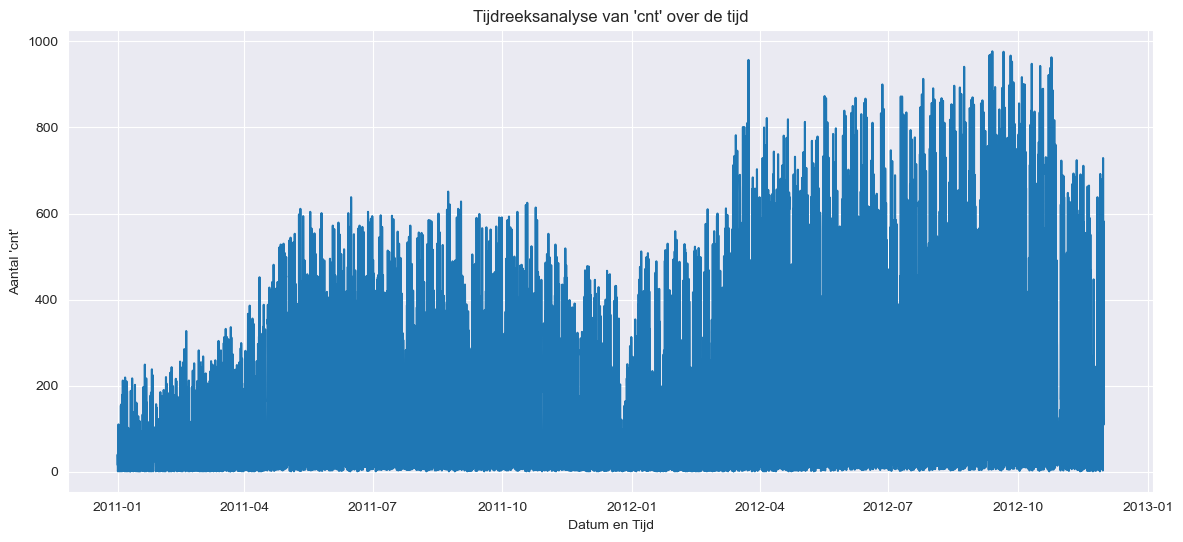

In [99]:
# Tijdreeksanalyse van 'cnt' over de tijd
plt.figure(figsize=(14, 6))
plt.plot(train["date_hour"], train["cnt"])
plt.title("Tijdreeksanalyse van 'cnt' over de tijd")
plt.xlabel("Datum en Tijd")
plt.ylabel("Aantal 'cnt'")
plt.show()

### Verdeling van de kolommen

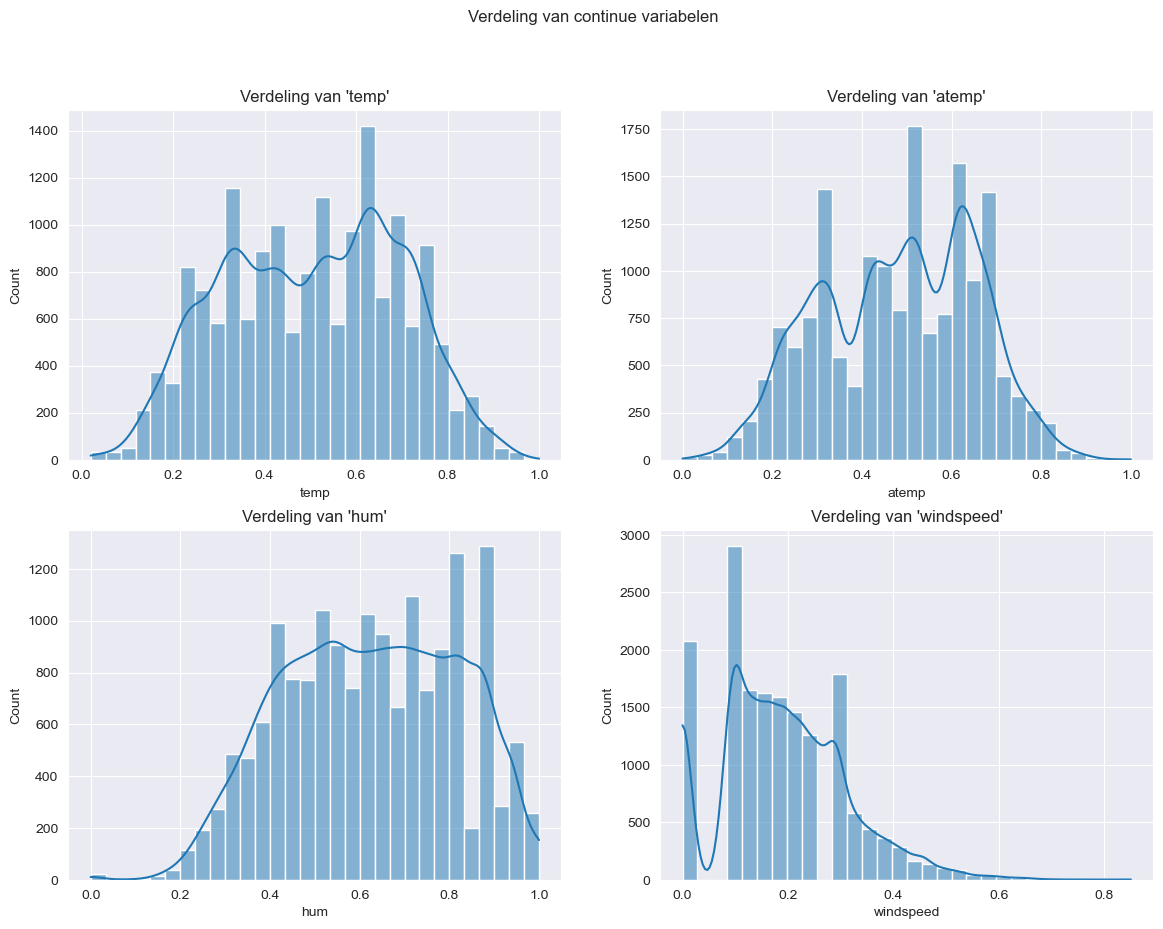

In [100]:
# Verdelingsplots van de continue variabelen
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Verdeling van continue variabelen")

sns.histplot(train["temp"], bins=30, kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Verdeling van 'temp'")

sns.histplot(train["atemp"], bins=30, kde=True, ax=axes[0, 1])
axes[0, 1].set_title("Verdeling van 'atemp'")

sns.histplot(train["hum"], bins=30, kde=True, ax=axes[1, 0])
axes[1, 0].set_title("Verdeling van 'hum'")

sns.histplot(train["windspeed"], bins=30, kde=True, ax=axes[1, 1])
axes[1, 1].set_title("Verdeling van 'windspeed'")

plt.show()

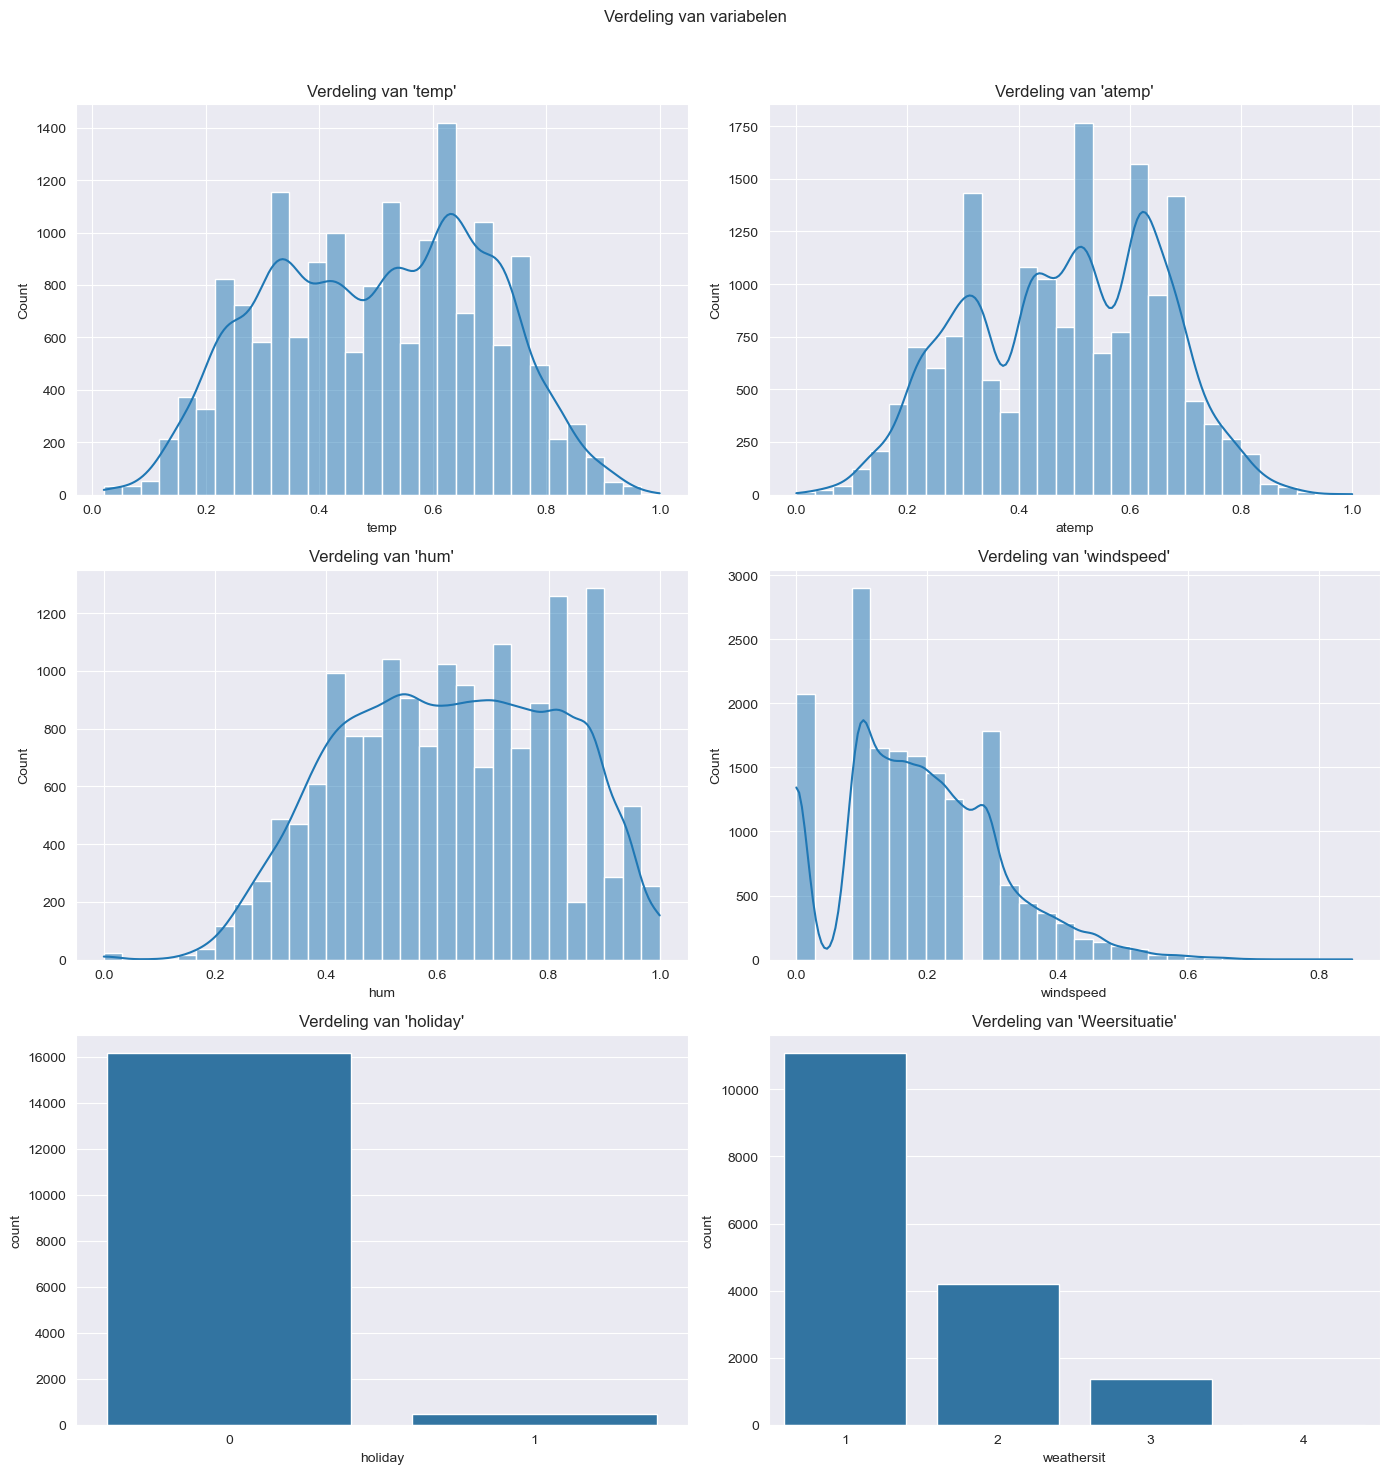

In [101]:
# Verdelingsplots van de continue variabelen
fig, axes = plt.subplots(3, 2, figsize=(14, 15))
fig.suptitle("Verdeling van variabelen")

# Continue variabelen
sns.histplot(train["temp"], bins=30, kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Verdeling van 'temp'")

sns.histplot(train["atemp"], bins=30, kde=True, ax=axes[0, 1])
axes[0, 1].set_title("Verdeling van 'atemp'")

sns.histplot(train["hum"], bins=30, kde=True, ax=axes[1, 0])
axes[1, 0].set_title("Verdeling van 'hum'")

sns.histplot(train["windspeed"], bins=30, kde=True, ax=axes[1, 1])
axes[1, 1].set_title("Verdeling van 'windspeed'")

# Categorische variabelen
sns.countplot(x=train["holiday"], ax=axes[2, 0])
axes[2, 0].set_title("Verdeling van 'holiday'")

sns.countplot(x=train["weathersit"], ax=axes[2, 1])
axes[2, 1].set_title("Verdeling van 'Weersituatie'")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Relaties

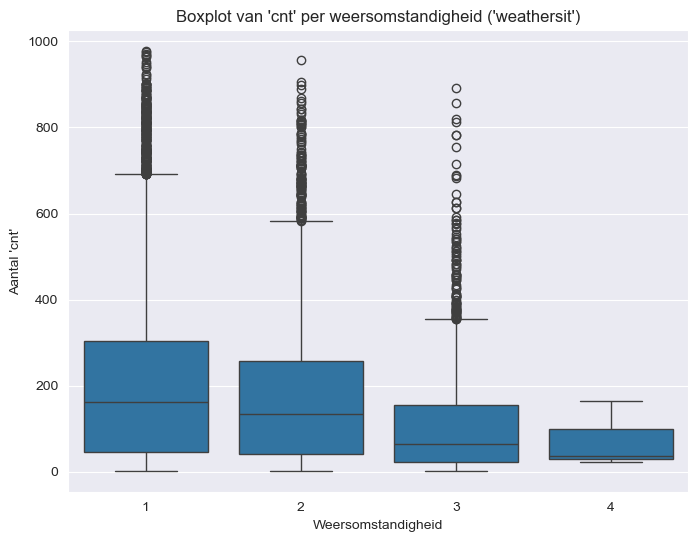

In [102]:
plt.figure(figsize=(8, 6))
sns.boxplot(x="weathersit", y="cnt", data=train)
plt.title("Boxplot van 'cnt' per weersomstandigheid ('weathersit')")
plt.xlabel("Weersomstandigheid")
plt.ylabel("Aantal 'cnt'")
plt.show()

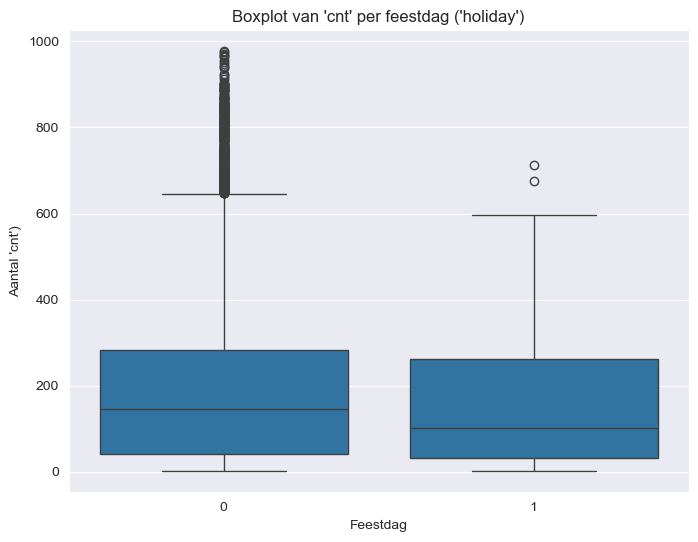

In [103]:
plt.figure(figsize=(8, 6))
sns.boxplot(x="holiday", y="cnt", data=train)
plt.title("Boxplot van 'cnt' per feestdag ('holiday')")
plt.xlabel("Feestdag")
plt.ylabel("Aantal 'cnt')")
plt.show()

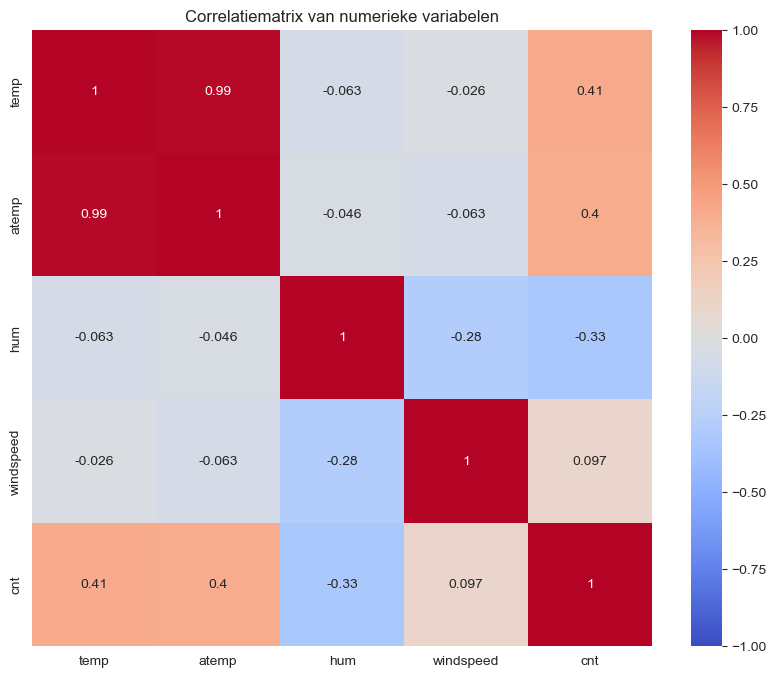

In [104]:
# Correlatiematrix van numerieke variabelen
plt.figure(figsize=(10, 8))
correlation_matrix = train[["temp", "atemp", "hum", "windspeed", "cnt"]].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlatiematrix van numerieke variabelen")
plt.show()

**Tijdreeksanalyse van cnt:**

- Het aantal cnt neemt in de loop van de tijd toe, met duidelijke schommelingen die mogelijk verband houden met seizoenen of andere tijdsgebonden factoren.

**Verdelingsplots van continue variabelen:**

- temp en atemp hebben een bijna normale verdeling, met een piek rond 0,6.
- hum heeft een vrij gelijkmatige verdeling, maar met een lichte piek bij hogere luchtvochtigheidswaarden.
- windspeed heeft een piek bij lagere waardes, wat suggereert dat de meeste cnt lage windsnelheden hebben.
- Er blijkt heel weinig holidays te zijn
- De verdeling bij weeromstaandigheid is er te zien dat de aantallen per waarde daalt, waarbij 1 de hoogste is. 

**Boxplots van cnt per weersomstandigheid:**

- Het aantal cnt is het hoogst bij heldere weersomstandigheden en neemt af bij zwaardere weersomstandigheden. Dit suggereert dat slecht weer invloed kan hebben op de activiteit.

**Boxplots van cnt per feestdag (holiday):**

- Er zijn geen significante verschillen in cnt tussen feestdagen en gewone dagen, hoewel de variatie iets groter is op gewone dagen.

**Correlatiematrix:**

- temp en atemp zijn sterk gecorreleerd (0,99), wat logisch is omdat beide temperatuurgerelateerd zijn.
- temp en atemp vertonen een matige positieve correlatie met cnt, wat aangeeft dat hogere temperaturen mogelijk gepaard gaan met meer cnt.
- hum heeft een zwakke negatieve correlatie met cnt, wat kan betekenen dat hogere luchtvochtigheid  een negatieve invloed kan hebben op de cnt.
- temp en atemp vertonen vaak een matige positieve correlatie met cnt. Dit wijst erop dat hogere temperaturen kunnen leiden tot een toename in het aantal cnt.

**Feature Selection:**  
Aan de hand van de visualisaties zijn de volgende features gekozen:
- weathersit (weersomstandigheid)
- temp 

#### Controle op Uitschieters

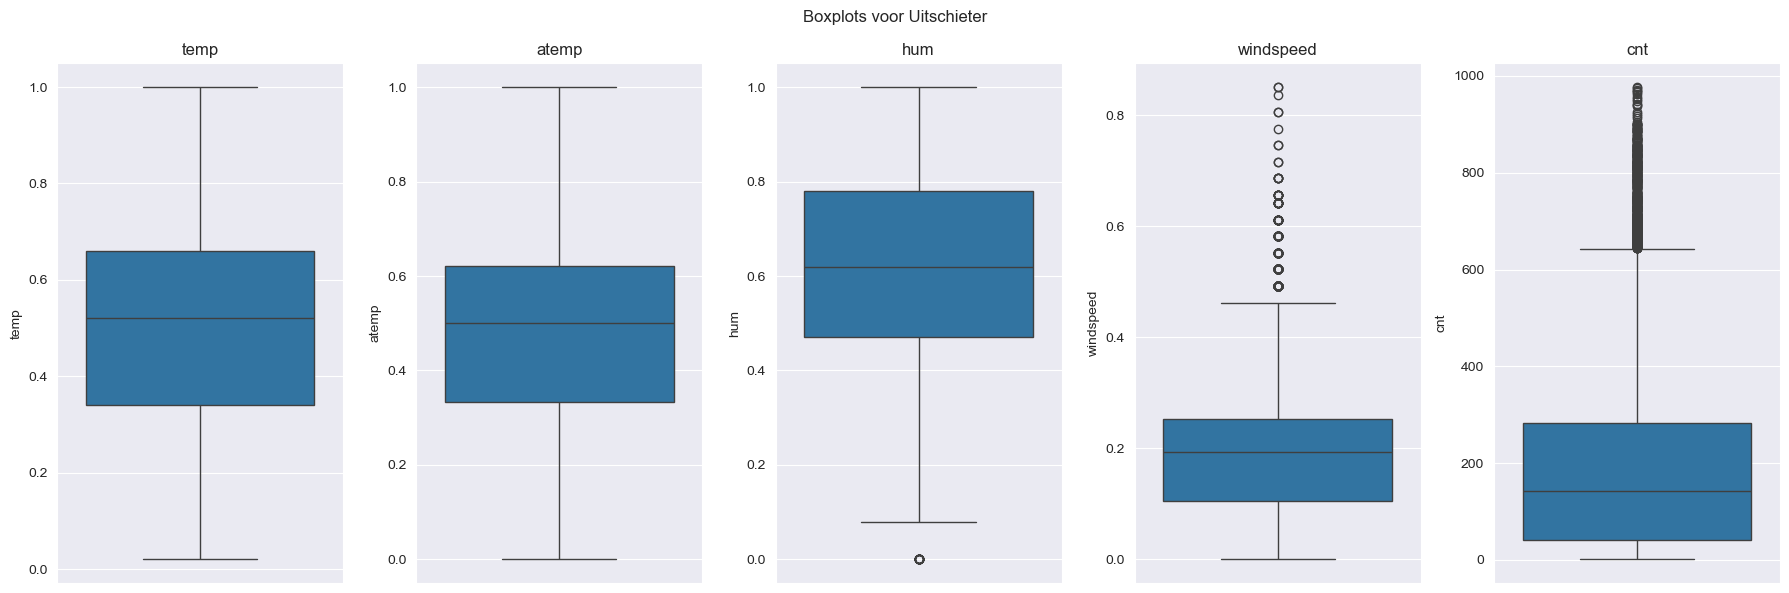

In [105]:
fig, axes = plt.subplots(1, 5, figsize=(18, 6))
fig.suptitle("Boxplots voor Uitschieter")

cols_names = ["temp", "atemp", "hum", "windspeed", "cnt"]
for i, col in enumerate(cols_names):
    sns.boxplot(y=train[col], ax=axes[i])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

- hum: Er zijn enkele waarden dicht bij de minimumdie als outliers kunnen worden beschouwd.
- windspeed : Er zijn een paar lage waarden die als uitschieters worden beschouwd.
- cnt: Er zijn een paar hoge waarden die buiten het interkwartielbereik liggen en als uitschieters kunnen worden gezien.

In [111]:
# Nieuwe kolommen toevoegen voor de tijdreeksanalyse van 'cnt'
train["year"] = train["date_hour"].dt.year
train["month"] = train["date_hour"].dt.month
train["day"] = train["date_hour"].dt.day
train["hour"] = train["date_hour"].dt.hour
train["weekday"] = train["date_hour"].dt.weekday
display(train.head())

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,cnt,year,month,day,hour,weekday
0,2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0,16,2011,1,1,0,5
1,2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0,40,2011,1,1,1,5
2,2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0,32,2011,1,1,2,5
3,2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0,13,2011,1,1,3,5
4,2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0,1,2011,1,1,4,5


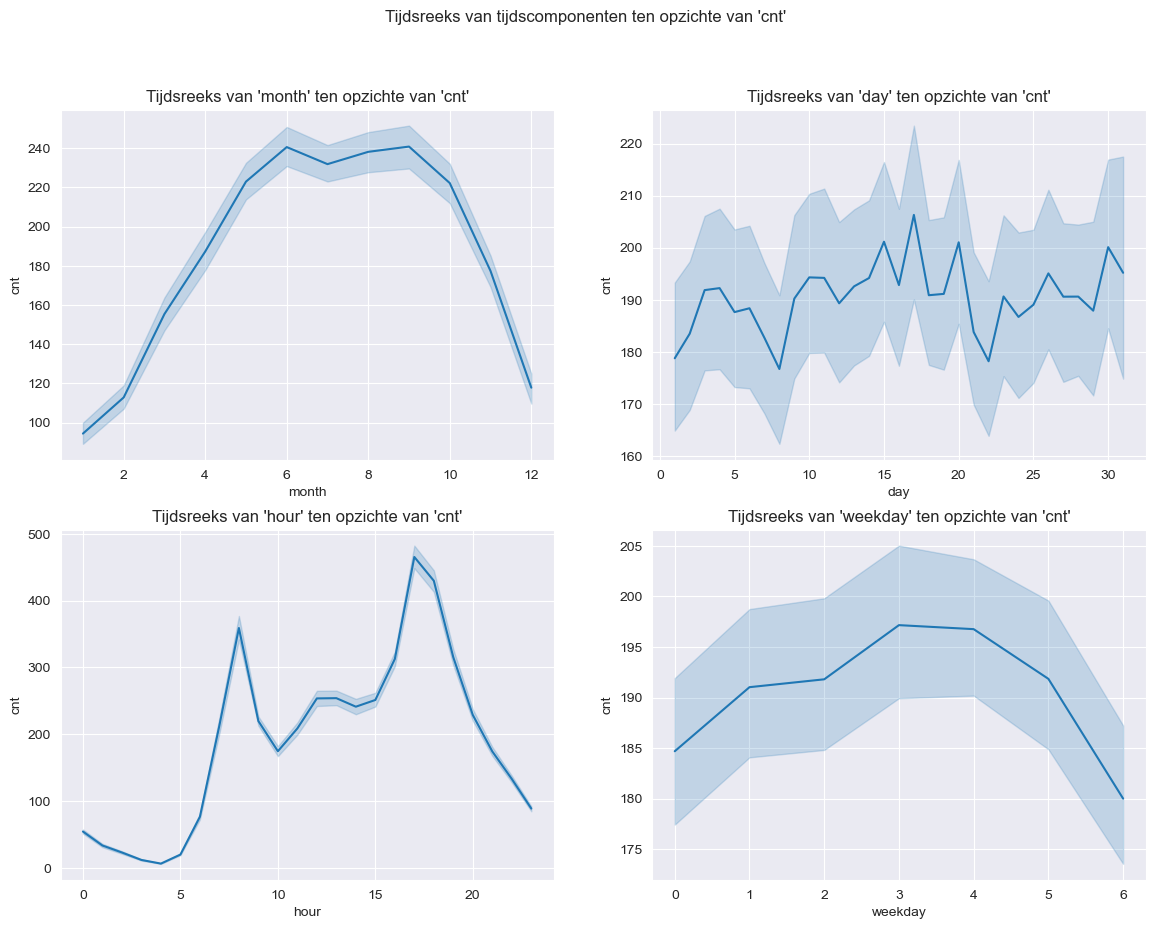

In [115]:
# Tijdsreeksplots van de nieuwe kolommen ten opzichte van 'cnt'
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Tijdsreeks van tijdscomponenten ten opzichte van 'cnt'")

# Tijdscomponenten ten opzichte van 'cnt'
sns.lineplot(x='month', y='cnt', data=train, ax=axes[0, 0])
axes[0, 0].set_title("Tijdsreeks van 'month' ten opzichte van 'cnt'")

sns.lineplot(x='day', y='cnt', data=train, ax=axes[0, 1])
axes[0, 1].set_title("Tijdsreeks van 'day' ten opzichte van 'cnt'")

sns.lineplot(x='hour', y='cnt', data=train, ax=axes[1, 0])
axes[1, 0].set_title("Tijdsreeks van 'hour' ten opzichte van 'cnt'")

sns.lineplot(x='weekday', y='cnt', data=train, ax=axes[1, 1])
axes[1, 1].set_title("Tijdsreeks van 'weekday' ten opzichte van 'cnt'")

# plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Modeling

### Decision Tree Regressor
Een Decision Tree is een visuele beslissings- en voorspellingsmethode die werkt als een boomstructuur.  
Het model maakt gebruik van knopen (nodes) en takken (branches) om beslissingen te nemen of voorspellingen te doen.

#### Onderdelen van een Decision Tree
- Beslissingsknopen (Decision Nodes): Stellen een voorwaarde of test voor (bijvoorbeeld Temperatuur > 5).
- Eindknopen (End Nodes/Leaf Nodes): Geven het uiteindelijke resultaat of de voorspelling (bijvoorbeeld "Ja", "Nee" of in dit geval een getal want het is een regressie probleem).
- Takken (Branches): Verbinden de knopen en tonen de uitkomst van de voorwaarde (bijvoorbeeld waar of onwaar).
- De boom breidt zich uit op basis van logische voorwaarden en leidt tot verschillende mogelijke uitkomsten.

#### Supervised Learning en Decision Trees
Decision Trees behoren tot de categorie supervised learning:
- Input: Historische data met kenmerken (features) en bijbehorende uitkomsten.
- Output: Een boommodel dat nieuwe data kan gebruiken om voorspellingen te doen.  

Ze kunnen omgaan met:
- Continue variabelen: Bijvoorbeeld temperatuur- of een aantal van iets.
- Categorische variabelen: Bijvoorbeeld classificaties als "Regen" of "Geen  regen."  

Werking van een Decision Tree:
- Data opsplitsen: De dataset wordt opgedeeld in kleinere subsets op basis van voorwaarden.
- Voorspellen: Het model voorspelt resultaten of beslissingen door de boom te volgen naar de eindknopen.

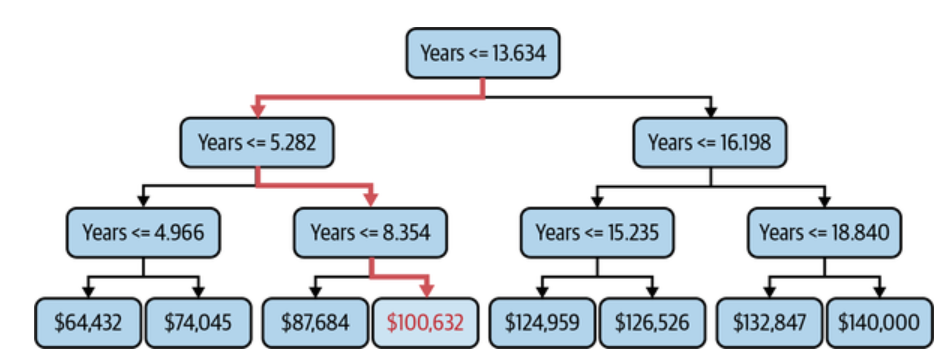  

Foto: https://vitalflux.com/decision-tree-regression-linear-regression-differences-examples/  

Uitleg: https://www.geeksforgeeks.org/python-decision-tree-regression-using-sklearn/

### Random Forest Regressor  
Random Forest Regression is een machine learning-techniek die gebruikt wordt voor het voorspellen van numerieke waarden. Het combineert de voorspellingen van meerdere decision trees om overfitting te verminderen en de nauwkeurigheid te verbeteren.

#### Kenmerken van Random Forest
- Het is een ensemble learning-methode: meerdere decision trees worden gecombineerd om een stabielere en meer nauwkeurige voorspelling te maken.
- Kan gebruikt worden voor zowel classificatie- als regressieproblemen.  

#### Werking
- Bootstrap: Willekeurige subsets van rijen en features worden uit de dataset gemaakt met **teruglegging**. Elke decision tree wordt getraind op een van deze datasets.
- Aggregatie:
    - Classificatie: De uiteindelijke voorspelling wordt bepaald door de meerderheid van de voorspellingen (Majority voting).
    - Regressie: Het gemiddelde van de voorspellingen van alle decision trees wordt gebruikt.  

#### Voordelen
- Vermindert variantie: Individuele decision trees hebben een hoge variantie, maar door ze te combineren, wordt het model stabieler.
- Betrouwbaarder: Het eindresultaat is niet afhankelijk van één enkele decision tree, maar van een verzameling decision trees.  

De reden voor deze modelkeuze is omdat deze model geschikt is voor complexe en grote datasets, maar ook omdat deze model niet afhankelijk is van lineaire relaties.  
Random Forest maakt gebruik van technieken zoals Bootstrap and Aggregation (bagging) om robuuste en betrouwbare voorspellingen te genereren.

Uitleg: https://www.geeksforgeeks.org/random-forest-regression-in-python/

## Results

## Conclusion & Advice

## Sources